In [1]:
import time

import optuna
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
from category_encoders.woe import WOEEncoder
from lightgbm import LGBMClassifier, early_stopping, log_evaluation, reset_parameter
from plotly.subplots import make_subplots
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split
from tqdm import tqdm

import polars as pl

# Practitioner's Guide to Hyper-Parameter Tuning for Random Forest & GBTs

The aim of this notebook is to provide a practical advice on which parameters to tune and which tools to use for HP tuning. This notebook focuses specifically on Random Forest and Gradient Boosted Trees (LightGBM) since these are the models that are used the most in the industry for tabular problems. `Optuna` is used as the main library for tuning since it's model-agnostic and has a very simple API where you just need to specify the optimisation function and all the actual optimisation magic happens behind the scenes. At first, we'll cover some theory and then we'll see the HP tuning in action on a simulated (but very realistic) dataset.  

## What are Hyperparameters?
You can think of hyperparameters as levers that you can pull to improve (or degrade) the model. In general (very broad generalization), we have 3 groups of hyperparameters for tree-based ensembles:

* Model parameters - affect the structure of the algorithm used to train the model (e.g., maximum depth).
* Training parameters - affect the training process of a model (e.g., tolerance).
* Ensembling parameters - affect the ensembling logic used in bagging/boosting (e.g., number of trees).

Keep in mind that these 3 groups are quite arbitrary, and some parameters might fit into multiple categories. Still, it's a useful framework to have in mind when you explore available hyperparameters. It's always a good idea to go through the model documentation to understand what each parameter does before attempting to tune them.

## How to Tune Hyperparameters

### Bias-Variance Trade-off
Even though tuning parameters of ML models might seem like a dark art of throwing things at a wall and seeing what sticks, there's actually logic to (most of) it. Remember the bias/variance trade-off? The concept that says that as the models get progressively more complex, they can fit more complex data (low bias) but will get more susceptible to fluctuations in the training data (high variance). In contrast, simple models will have high bias and low variance. <br><br>
> Hyper-parameter tuning is the process of finding an optimal point in bias-variance trade-off by changing the model (and training) parameters available 
<br><br>

![image](bv_tradeoff.png)

Typically, you need 4 components for HP tuning:

* Model
* Hyperparameter search space
* Cross-validation scheme / validation set
* Scoring function

Picking a model is always the first step since the hyperparameter search space will depend on the model you choose. In this tutorial, we'll focus on Random Forest and LightGBM. You'll see in the following sections how to define an appropriate search space for these two models.

### Cross-validation VS Validation Set
When it comes to using cross-validation or just a validation set, this will depend on your data size. Working with large data makes it almost impossible to use cross-validation, so a single validation set will have to do. The advantage of cross-validation is that you can get a good estimation of your expected metric because you get a mean and standard deviation from your folds. Using a validation set, you just get a point estimate which can be biased. Hence, **it's important that you don't overfit to your validation set**. This can happen if you keep tuning your model to squeeze the final decimal points of performance. For example, improvement in PR AUC from 0.18 to 0.1805 is not worth it if your hyperparameters stop looking sensible.

### Scoring Function
This is the metric that you will be optimizing on your validation set. If you choose it incorrectly, all your optimization will go to waste. For example, for binary classification problems, it makes absolutely no sense to optimize for Precision because this will create models that make all the predictions equal to 0. The same with Recall; a perfect Recall score can be achieved if all the predictions are 1. Hence, think wisely about the metric! For binary classification, I prefer to use ROC AUC (or PR AUC for imbalanced problems). For regression models, RMSE usually works quite well (R2 or MAPE are bad choices).

### Keep in Mind

#### Data Size Effect
One important relationship to keep in mind is that **the more data (observations and features) you have, the more complex the model can become**. Note the word "can"; it's not necessary that the optimal model will be very complex, but if you have a lot of data, you can experiment with wider ranges of parameters with less risk of overfitting. For example, if you have 1,000 observations and 3 features, it's highly unlikely that the optimal `max_depth` parameter will be 20—you just won't have enough data to avoid overfitting with such a deep tree. On the other hand, with 10,000,000 rows, you can very well end up with a large `max_depth` if the dataset is complicated enough to require it.

#### Complicated vs Simple Models
Some models are inherently more complex (high variance, low bias)—e.g., Gradient Boosting—and some are inherently simple (low variance, high bias)—e.g., logistic regression. Nevertheless, you can easily tune the more "complex" model to have higher bias than the "simple" model. For example, a Gradient Boosted Tree with `n_estimators=1` and `max_depth=1` will be simpler than a Decision Tree with `max_depth=20`.

Now that you're familiar with these basics, let's jump into a practical part!

## Data
You can get the dataset used in this notebook from [Kaggle](https://www.kaggle.com/datasets/sgpjesus/bank-account-fraud-dataset-neurips-2022). It's quite a good simulation of bank transactions with the main task being fraud detection. It's relatively large and complex, yet it's still manageable to tune on your local laptop. If your laptop struggles with this dataset, it's okay to take a random sample of e.g.  500,000 rows.

In [2]:
data = pl.read_csv('Base.csv')

In [3]:
categorical_features = [
    "payment_type",
    "employment_status",
    "housing_status",
    "source",
    "device_os",
]
numerical_features = [
    "income",
    "name_email_similarity",
    "prev_address_months_count",
    "current_address_months_count",
    "customer_age",
    "days_since_request",
    "intended_balcon_amount",
    "zip_count_4w",
    "velocity_6h",
    "velocity_24h",
    "velocity_4w",
    "bank_branch_count_8w",
    "date_of_birth_distinct_emails_4w",
    "credit_risk_score",
    "email_is_free",
    "phone_home_valid",
    "phone_mobile_valid",
    "bank_months_count",
    "has_other_cards",
    "proposed_credit_limit",
    "foreign_request",
    "session_length_in_minutes",
    "keep_alive_session",
    "device_distinct_emails_8w",
    "device_fraud_count",
]
features = numerical_features + categorical_features

label = "fraud_bool"
time_split = "month"

### Data Split

We'll perform a time-based split using the `month` variable. This type of split is usually the best at approximating a model's performance on the unseen data that it will encounter after deployment. Note that the choice of a validation set is crucial for HP tuning. If our holdout datasets are not indicative of real data or if they provide a biased image of the model's generalisability, the tuning process will only make our model worse.

In [4]:
train_months = [0, 1, 2, 3, 4]
val_months = [5]
test_months = [6, 7]

In [5]:
train = data.filter(pl.col("month").is_in(train_months)).to_pandas()
print('Train samples:', train.shape[0])
print('Train fraud samples:', train['fraud_bool'].sum())

val = data.filter(pl.col("month").is_in(val_months)).to_pandas()
print('\nVal samples:', val.shape[0])
print('Val fraud samples:', val['fraud_bool'].sum())

test = data.filter(pl.col("month").is_in(test_months)).to_pandas()
print('\nTest samples:', test.shape[0])
print('Test fraud samples:', test['fraud_bool'].sum())

Train samples: 675666
Train fraud samples: 6740

Val samples: 119323
Val fraud samples: 1411

Test samples: 205011
Test fraud samples: 2878


### Pre-processing

To make our life simpler, I'm going to process the categorical variables using Weight-of-Evidence. Having said that, usually, I'd recommend to use the in-built functionality of LightGBM to handle categorical variables. 

In [6]:
enc = WOEEncoder(cols=categorical_features, drop_invariant=True)
enc.fit(train, train[label])

train = enc.transform(train)
val = enc.transform(val)
test = enc.transform(test)

In [7]:
train.shape

(675666, 32)

## Random Forest

Random Forest is a go-to favourite of many seasoned DS because it requires very little hyperparameter tuning. Still, there are some parameters that we can tweak to make the model more/less regularised. Parameters available:
* `n_estimators` -  the number of decision trees in the forest
* `max_depth` - maximum depth of a tree in the forest. Higher - more variance, less - more bias
* `min_samples_leaf` - minimum samples required to be in a leaf. Higher - more bias, less more vairance
* `max_features` - number of features to consider when looking for the best split
* `max_samples` - number of samples to draw from X to train a tree

### Base Parameters

In [16]:
rf_default = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf_default.fit(train[features], train[label])

RandomForestClassifier(n_jobs=-1)

In [27]:
rf_base_pred_train = rf_default.predict_proba(train[features])[:, 1]
rf_base_pred_val = rf_default.predict_proba(val[features])[:, 1]

pr_auc_base_val = average_precision_score(val[label], rf_base_pred_val)
pr_auc_base_train = average_precision_score(train[label], rf_base_pred_train)

print('Base RF Train PR AUC:', pr_auc_base_train)
print('Base RF Validation PR AUC:', pr_auc_base_val)

Base RF Train PR AUC: 0.9999999999999999
Base RF Validation PR AUC: 0.12814533948021295


From train/val performance mismatch we can see that the default parameters will cause your model to severly overfit. No wonder, since we don't really control the depth of our trees and `min_samples_leaf` are set to 1. 

### Effect of Num Trees
Number of trees makes the model more robust but the benefit is only visible until a certain point. To demonstrate this, let's train a few models with increasing number of trees.

In [8]:
num_trees = [10, 50, 100, 200, 300, 500, 1000]
pr_aucs = []
time_to_train = []

for n in tqdm(num_trees):
    rf = RandomForestClassifier(n_estimators=n, n_jobs=-1)
    t0 = time.time()
    rf.fit(train[features], train[label])
    t1 = time.time()
    preds = rf.predict_proba(val[features])[:, 1]
    pr = average_precision_score(val[label], preds)

    pr_aucs.append(pr)
    time_to_train.append(t1 - t0)

100%|██████████| 7/7 [08:41<00:00, 74.47s/it] 


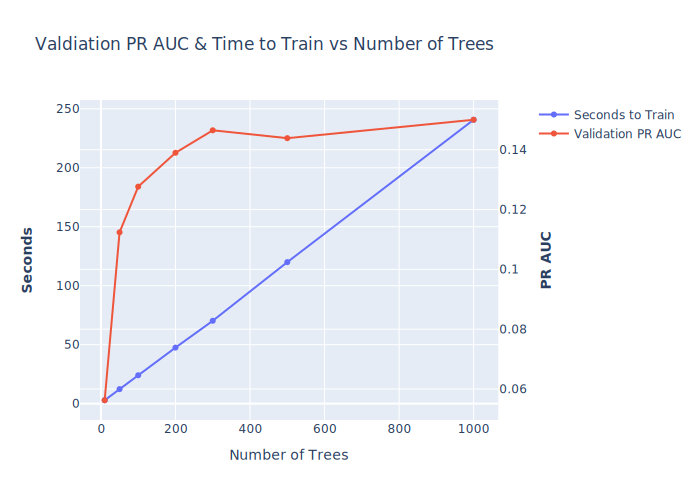

In [10]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Scatter(x=num_trees, y=time_to_train, name="Seconds to Train"),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter(x=num_trees, y=pr_aucs, name="Validation PR AUC"),
    secondary_y=True,
)
fig.update_layout(
    title_text="Valdiation PR AUC & Time to Train vs Number of Trees"
)
fig.update_xaxes(title_text="Number of Trees")
fig.update_yaxes(title_text="<b>Seconds</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>PR AUC</b>", secondary_y=True)

fig.show(renderer="svg")

As can be seen, improvements in performance is only up until a certain point (200 trees). After that mark, the performance stays relatively constant but the training speed increases. Keep in mind that the optimal number of trees will be different for every dataset, but it will rarely be as high as 1000. In practice, setting `num_trees` to 300 should be enough in most of the cases. If you're short on time, 100 will work fine as well.


Now, let's try to tune all the other parameters mentioned above.

In [13]:
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 10, 100)
    max_features = trial.suggest_float('max_features', 0.2, 0.9)
    max_samples = trial.suggest_float('max_samples', 0.3, 1)

    model = RandomForestClassifier(
        n_estimators=200,
        max_depth=max_depth,
        max_samples=max_samples,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        n_jobs=-1
    )

    model.fit(train[features], train[label])
    preds = model.predict_proba(val[features])[:, 1]
    pr = average_precision_score(val[label], preds)
    
    return pr

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best parameters found 
print("Best trial:")
trial = study.best_trial

print("Value: {:.4f}".format(trial.value))

print("Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-06-06 16:58:31,615] A new study created in memory with name: no-name-e8dac46d-86d2-48f5-ae2a-69ee3cfd7388
[I 2024-06-06 17:00:35,967] Trial 0 finished with value: 0.15704485656482786 and parameters: {'max_depth': 20, 'min_samples_leaf': 51, 'max_features': 0.6356999116426916, 'max_samples': 0.6270381157684181}. Best is trial 0 with value: 0.15704485656482786.
[I 2024-06-06 17:01:33,800] Trial 1 finished with value: 0.15446428742287244 and parameters: {'max_depth': 15, 'min_samples_leaf': 36, 'max_features': 0.5359931959399997, 'max_samples': 0.3773420731911866}. Best is trial 0 with value: 0.15704485656482786.
[I 2024-06-06 17:02:18,591] Trial 2 finished with value: 0.1100311561482043 and parameters: {'max_depth': 4, 'min_samples_leaf': 87, 'max_features': 0.8520804042246046, 'max_samples': 0.6606451873641764}. Best is trial 0 with value: 0.15704485656482786.
[I 2024-06-06 17:03:44,701] Trial 3 finished with value: 0.15378832280024743 and parameters: {'max_depth': 18, 'min_samp

Best trial:
Value: 0.1647
Params: 
    max_depth: 17
    min_samples_leaf: 33
    max_features: 0.24347427803049831
    max_samples: 0.6308326604955227


In [21]:
rf_tuned = RandomForestClassifier(
    n_estimators=200,
    max_depth=17,
    min_samples_leaf=33,
    max_features=0.2435,
    max_samples=0.6308,
    n_jobs=-1,
)

rf_tuned.fit(train[features], train[label])

train_preds = rf_tuned.predict_proba(train[features])[:, 1]
val_preds = rf_tuned.predict_proba(val[features])[:, 1]
test_preds = rf_tuned.predict_proba(test[features])[:, 1]

train_pr = average_precision_score(train[label], train_preds)
val_pr = average_precision_score(val[label], val_preds)
test_pr = average_precision_score(test[label], test_preds)

print('Tuned RF Train PR AUC:', train_pr)
print('Tuned RF Val PR AUC:', val_pr)
print('Tuned RF Test PR AUC:', test_pr)

Tuned RF Train PR AUC: 0.28008855385455533
Tuned RF Val PR AUC: 0.16141081824916093
Tuned RF Test PR AUC: 0.17326309785507252


The Validation PR AUC has improved from 0.128 to 0.161 which is a good sign. We can also see much less overfitting, since we're now controlling the complexity of individual trees. In other words, we've added bias to our model, which made it less prone to overfitting. This has in turn improved the generalisability of our model which made it more performant on unseen data. Keep this balance in mind, when tuning your models - **you want your model to be generalisable, but you also want it to be complex enough to learn from data**. 

## LightGBM

GBT based models (XGBoost, LightGBM, CatBoost) have all more or less converged at this point. So, pick your favourite and tune the hell out of it. My go-to facourite is LightGBM though, so I'll stick with it for this tutorial. Tuning GBTs is a bit more complex than Random Forest models, but it's nothing too complicated to be honest. At first, let's consider the available parameters.<br><br> **Note:** there are many more parameters available, but the ones you see below are the ones I usually tune. For a full list, see [here](https://lightgbm.readthedocs.io/en/latest/Parameters.html).

### Gradient Boosting Parameters
These parameters control how the gradient boosting algorithm will work e.g. how long will the training take.
* learning_rate - how much each learned tree changes the output. Higher means faster training but less accurate models.
* n_estimators - number of trees to build. Higher means lower bias. The optimal number is tightly linked with the `learning_rate`. Lower learning rate will require more trees to be built.

### Indivudal tree parameters
These parameters control the complexity of individual trees.
#### Tree complexity:
* num_leaves - maximum number of leaves per tree. LGBM is building its trees leaf-wise, so this is the main complexity parameter. Higher values mean more variance and less bias.
* max_depth - maximum depth of a tree. You can also control the total depth of a tree. Optimal number will depend on the number of leaves, so read the discussion [here](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html#:~:text=num_leaves.%20This%20is,than%20depth%2Dwise.).
* min_child_samples - minimum number of samples in a leaf. This parameter is very important to control overfitting and its optimal value depends on the number of training samples and num_leaves. Larger values mean more bias, so less overfitting. For larger datasets, setting it to 100s or even 1000s should work well. Small datasets will require smaller number since we still want our trees to build.

#### Bagging parameters:
* subsample - ratio of samples used when constructing a tree. Larger values make the trees build faster since you're using less data. Additionally, it should improve generalisability of your model since every tree will be trained on different data. Optimal value will depend on the number of samples. With large data, setting it to the range [0.5 - 0.8] should work well. For smaller datasets, don't use it. 
* colsample_bytree - ratio of features when constructing a tree. Optimal number depends on number of features. I prefer to set it to a range between [0.6 - 0.9] when the number of features is < 20. With more than 20 features, range of [0.2 - 0.5] should work well.
#### Control Overfitting:
* reg_lambda - L2 regularisation parameter. This simply adds more regularisation to make trees shallower. Increases bias.

<br>
With this long introduction out of the way, let's build our baseline.

### Baseline

In [28]:
lgb = LGBMClassifier()
lgb.fit(train[features], train[label])


Base LGBM PR AUC: 0.16157203528200753


In [30]:
lgb_base_preds_train = lgb.predict_proba(train[features])[:, 1]
lgb_base_preds_val = lgb.predict_proba(val[features])[:, 1]
pr_auc_lgb_base_train = average_precision_score(train[label], lgb_base_preds_train)
pr_auc_lgb_base_val = average_precision_score(val[label], lgb_base_preds_val)

print('Base LGBM Train PR AUC:', pr_auc_lgb_base_train)
print('Base LGBM Val PR AUC:', pr_auc_lgb_base_val)

Base LGBM Train PR AUC: 0.28191799077519847
Base LGBM Val PR AUC: 0.16157203528200753


Out of the box, the model performs much better than RF. It overfits less, and the inference speed is also faster. This is due to the fact that the default hyperparameters set in LGBM are already quite good. However, an easy improvement to make is to:
* Use early stopping
* Use lower learning rate (and hence more trees)

### Number of trees and learning rate (with early stopping)
Let's set:
* Learning reate to `0.01`
* Number of estimators to `10,000` with early stopping of `30`

This means that we'll keep training until the validation score stops improving for 30 rounds. Hence, even though we've set our `n_estimators` so high, it will most likely never reach it.

In [33]:
lgb_full = LGBMClassifier(n_estimators=10000, learning_rate=0.01)
lgb_full.fit(
    train[features],
    train[label],
    eval_set=[(val[features], val[label])],
    callbacks=[log_evaluation(period=100), early_stopping(30)]
)

Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.0529607
[200]	valid_0's binary_logloss: 0.0503429
[300]	valid_0's binary_logloss: 0.049285
[400]	valid_0's binary_logloss: 0.0487125
[500]	valid_0's binary_logloss: 0.0483604
[600]	valid_0's binary_logloss: 0.0481839
[700]	valid_0's binary_logloss: 0.0480711
[800]	valid_0's binary_logloss: 0.0479972
[900]	valid_0's binary_logloss: 0.0479354
[1000]	valid_0's binary_logloss: 0.0478877
Early stopping, best iteration is:
[1048]	valid_0's binary_logloss: 0.0478709


LGBMClassifier(learning_rate=0.01, n_estimators=10000)

In [34]:
lgb_full_preds_train = lgb_full.predict_proba(train[features])[:, 1]
lgb_full_preds_val = lgb_full.predict_proba(val[features])[:, 1]
pr_auc_lgb_full_train = average_precision_score(train[label], lgb_full_preds_train)
pr_auc_lgb_full_val = average_precision_score(val[label], lgb_full_preds_val)

print('Fully Trained Train LGBM PR AUC:', pr_auc_lgb_full_train)
print('Fully Trained Val LGBM PR AUC:', pr_auc_lgb_full_val)

Fully Trained Train LGBM PR AUC: 0.28482254647122535
Fully Trained Val LGBM PR AUC: 0.18970866397418748


We've managed to increase the validation score without increasing the degree of overfitting. <br> **Important Note:** If you're short on time, doing this type of "optimisation" is your best bet at improve the results.

Now, let's tune all the other parameters mentioned above.

### Tuning
One interesting property of GBTs is that good parameters generalise across learning rates (mostly). I've discovered this idea in this [blog](https://randomrealizations.com/posts/xgboost-parameter-tuning-with-optuna/) and it has worked well for me in my work as well. So, in the tuning below, I'll be using learning rate of `0.1`, still with early stopping.

In [36]:
def objective(trial):
    num_leaves = trial.suggest_int('num_leaves', 16, 256)
    min_child_samples = trial.suggest_int("min_child_samples", 10, 100)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.1, 0.7)
    subsample = trial.suggest_float("subsample", 0.7, 1)
    reg_lambda = trial.suggest_float("reg_lambda", 0, 10)

    lgb = LGBMClassifier(
        n_estimators=100000,
        learning_rate=0.1,
        num_leaves=num_leaves,
        min_child_samples=min_child_samples,
        colsample_bytree=colsample_bytree,
        subsample=subsample,
        reg_lambda=reg_lambda,
        verbose=-1
    )

    lgb.fit(
        train[features],
        train[label],
        eval_set=[(val[features], val[label])],
        callbacks=[log_evaluation(period=100), early_stopping(30)]
    )

    lgb_preds = lgb.predict_proba(val[features])[:, 1]
    pr = average_precision_score(val[label], lgb_preds)

    return pr


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2024-06-26 12:02:58,435] A new study created in memory with name: no-name-3073ce0a-ac3f-4d0f-82e4-f11d47b21757


Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.0480609
Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.0480269


[I 2024-06-26 12:03:02,106] Trial 0 finished with value: 0.18816359973694827 and parameters: {'num_leaves': 75, 'min_child_samples': 49, 'colsample_bytree': 0.6568390725374141, 'subsample': 0.8989992784449374, 'reg_lambda': 7.458158058628989}. Best is trial 0 with value: 0.18816359973694827.


Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.047654


[I 2024-06-26 12:03:06,197] Trial 1 finished with value: 0.19562628201135104 and parameters: {'num_leaves': 79, 'min_child_samples': 91, 'colsample_bytree': 0.25310613836086315, 'subsample': 0.9415792042416072, 'reg_lambda': 5.830627729938015}. Best is trial 1 with value: 0.19562628201135104.


Early stopping, best iteration is:
[97]	valid_0's binary_logloss: 0.0476325
Training until validation scores don't improve for 30 rounds


[I 2024-06-26 12:03:12,346] Trial 2 finished with value: 0.1731203003897835 and parameters: {'num_leaves': 225, 'min_child_samples': 77, 'colsample_bytree': 0.5485563696205832, 'subsample': 0.8563972883068809, 'reg_lambda': 2.481542581698845}. Best is trial 1 with value: 0.19562628201135104.


Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.0487904
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.0482098
Early stopping, best iteration is:
[102]	valid_0's binary_logloss: 0.0481827


[I 2024-06-26 12:03:18,544] Trial 3 finished with value: 0.1854599327583057 and parameters: {'num_leaves': 134, 'min_child_samples': 30, 'colsample_bytree': 0.28056908946099735, 'subsample': 0.9165327927329201, 'reg_lambda': 2.7169551875483036}. Best is trial 1 with value: 0.19562628201135104.


Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.0489182
Early stopping, best iteration is:
[72]	valid_0's binary_logloss: 0.0487963


[I 2024-06-26 12:03:25,685] Trial 4 finished with value: 0.1706834710390068 and parameters: {'num_leaves': 225, 'min_child_samples': 51, 'colsample_bytree': 0.6374155176970647, 'subsample': 0.8848078145594518, 'reg_lambda': 3.5401163547956305}. Best is trial 1 with value: 0.19562628201135104.


Training until validation scores don't improve for 30 rounds


[I 2024-06-26 12:03:30,402] Trial 5 finished with value: 0.17520767931405706 and parameters: {'num_leaves': 142, 'min_child_samples': 72, 'colsample_bytree': 0.6632130719169284, 'subsample': 0.786663936094754, 'reg_lambda': 2.8352733469190037}. Best is trial 1 with value: 0.19562628201135104.


Early stopping, best iteration is:
[66]	valid_0's binary_logloss: 0.0486302
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.047757


[I 2024-06-26 12:03:33,631] Trial 6 finished with value: 0.19124269515239578 and parameters: {'num_leaves': 29, 'min_child_samples': 98, 'colsample_bytree': 0.5845597792076674, 'subsample': 0.9221131010439376, 'reg_lambda': 3.0455912458017673}. Best is trial 1 with value: 0.19562628201135104.


Early stopping, best iteration is:
[146]	valid_0's binary_logloss: 0.0477295
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.0480016


[I 2024-06-26 12:03:38,897] Trial 7 finished with value: 0.18695537721712913 and parameters: {'num_leaves': 114, 'min_child_samples': 37, 'colsample_bytree': 0.47602807745296827, 'subsample': 0.9542888758680156, 'reg_lambda': 8.161230499455751}. Best is trial 1 with value: 0.19562628201135104.


Early stopping, best iteration is:
[87]	valid_0's binary_logloss: 0.0479264
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.0479063


[I 2024-06-26 12:03:43,687] Trial 8 finished with value: 0.18801049995978905 and parameters: {'num_leaves': 110, 'min_child_samples': 80, 'colsample_bytree': 0.3934997546479947, 'subsample': 0.9892372085134977, 'reg_lambda': 6.976954651996453}. Best is trial 1 with value: 0.19562628201135104.


Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.0478599
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.0475887
[200]	valid_0's binary_logloss: 0.0474886


[I 2024-06-26 12:03:46,796] Trial 9 finished with value: 0.19370524634557656 and parameters: {'num_leaves': 18, 'min_child_samples': 17, 'colsample_bytree': 0.4271077403285033, 'subsample': 0.8587524008630498, 'reg_lambda': 7.226887645181006}. Best is trial 1 with value: 0.19562628201135104.


Early stopping, best iteration is:
[211]	valid_0's binary_logloss: 0.0474657
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.0481236
Early stopping, best iteration is:
[148]	valid_0's binary_logloss: 0.0478012


[I 2024-06-26 12:03:55,277] Trial 10 finished with value: 0.19431860539518628 and parameters: {'num_leaves': 178, 'min_child_samples': 99, 'colsample_bytree': 0.10435352561968941, 'subsample': 0.7200312214096583, 'reg_lambda': 9.97416266003526}. Best is trial 1 with value: 0.19562628201135104.


Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.0481442
[200]	valid_0's binary_logloss: 0.0477466
Early stopping, best iteration is:
[183]	valid_0's binary_logloss: 0.0477101


[I 2024-06-26 12:04:05,469] Trial 11 finished with value: 0.19594196009349915 and parameters: {'num_leaves': 176, 'min_child_samples': 100, 'colsample_bytree': 0.11350869852871501, 'subsample': 0.7170998167860583, 'reg_lambda': 9.886577342225253}. Best is trial 11 with value: 0.19594196009349915.


Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.0486184
Early stopping, best iteration is:
[131]	valid_0's binary_logloss: 0.0484307


[I 2024-06-26 12:04:14,757] Trial 12 finished with value: 0.18360476044883145 and parameters: {'num_leaves': 184, 'min_child_samples': 91, 'colsample_bytree': 0.12769791581090115, 'subsample': 0.7874887005208144, 'reg_lambda': 0.774715995951877}. Best is trial 11 with value: 0.19594196009349915.


Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.0476336
Early stopping, best iteration is:
[152]	valid_0's binary_logloss: 0.047486


[I 2024-06-26 12:04:19,293] Trial 13 finished with value: 0.19149996324284893 and parameters: {'num_leaves': 59, 'min_child_samples': 62, 'colsample_bytree': 0.20718687489288343, 'subsample': 0.7210830600248983, 'reg_lambda': 5.155260978684704}. Best is trial 11 with value: 0.19594196009349915.


Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.0482502
Early stopping, best iteration is:
[93]	valid_0's binary_logloss: 0.048222


[I 2024-06-26 12:04:29,149] Trial 14 finished with value: 0.18630081160539247 and parameters: {'num_leaves': 256, 'min_child_samples': 85, 'colsample_bytree': 0.28293342245399844, 'subsample': 0.8018574299118013, 'reg_lambda': 9.452363984460801}. Best is trial 11 with value: 0.19594196009349915.


Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.0477719
Early stopping, best iteration is:
[159]	valid_0's binary_logloss: 0.0476305


[I 2024-06-26 12:04:34,663] Trial 15 finished with value: 0.1904008305650176 and parameters: {'num_leaves': 74, 'min_child_samples': 67, 'colsample_bytree': 0.20195783927308436, 'subsample': 0.9937712337868849, 'reg_lambda': 5.44776857329194}. Best is trial 11 with value: 0.19594196009349915.


Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.0480097
Early stopping, best iteration is:
[92]	valid_0's binary_logloss: 0.0479651


[I 2024-06-26 12:04:41,656] Trial 16 finished with value: 0.18728953333768195 and parameters: {'num_leaves': 167, 'min_child_samples': 89, 'colsample_bytree': 0.32915906195643174, 'subsample': 0.7511918485495612, 'reg_lambda': 8.823539504491565}. Best is trial 11 with value: 0.19594196009349915.


Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.0479031
Early stopping, best iteration is:
[136]	valid_0's binary_logloss: 0.0477594


[I 2024-06-26 12:04:47,845] Trial 17 finished with value: 0.19405770762512117 and parameters: {'num_leaves': 102, 'min_child_samples': 98, 'colsample_bytree': 0.18599201848465285, 'subsample': 0.8225699871139102, 'reg_lambda': 6.389025534347315}. Best is trial 11 with value: 0.19594196009349915.


Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.0482233
Early stopping, best iteration is:
[112]	valid_0's binary_logloss: 0.048197


[I 2024-06-26 12:04:55,334] Trial 18 finished with value: 0.1875780956668682 and parameters: {'num_leaves': 158, 'min_child_samples': 59, 'colsample_bytree': 0.2698520608454421, 'subsample': 0.9630173832255234, 'reg_lambda': 3.971751884429503}. Best is trial 11 with value: 0.19594196009349915.


Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.0479624


[I 2024-06-26 12:04:58,973] Trial 19 finished with value: 0.19080075187237627 and parameters: {'num_leaves': 46, 'min_child_samples': 86, 'colsample_bytree': 0.1632185031452959, 'subsample': 0.7501435279355184, 'reg_lambda': 0.05220507994950818}. Best is trial 11 with value: 0.19594196009349915.


Early stopping, best iteration is:
[149]	valid_0's binary_logloss: 0.0478219
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.0482032


[I 2024-06-26 12:05:05,850] Trial 20 finished with value: 0.1853477863129483 and parameters: {'num_leaves': 200, 'min_child_samples': 74, 'colsample_bytree': 0.35471855368495253, 'subsample': 0.9489489075234863, 'reg_lambda': 6.098306630540126}. Best is trial 11 with value: 0.19594196009349915.


Early stopping, best iteration is:
[74]	valid_0's binary_logloss: 0.0480853
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.0481037
Early stopping, best iteration is:
[163]	valid_0's binary_logloss: 0.047766


[I 2024-06-26 12:05:15,829] Trial 21 finished with value: 0.19518628727453874 and parameters: {'num_leaves': 192, 'min_child_samples': 99, 'colsample_bytree': 0.11291850268136286, 'subsample': 0.7000404659623689, 'reg_lambda': 9.43012129489173}. Best is trial 11 with value: 0.19594196009349915.


Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.04815
Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 0.0478378


[I 2024-06-26 12:05:26,546] Trial 22 finished with value: 0.19237824083634864 and parameters: {'num_leaves': 208, 'min_child_samples': 100, 'colsample_bytree': 0.10071465179544598, 'subsample': 0.7040841189454411, 'reg_lambda': 8.503660273358513}. Best is trial 11 with value: 0.19594196009349915.


Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.047801


[I 2024-06-26 12:05:32,656] Trial 23 finished with value: 0.19353788440546038 and parameters: {'num_leaves': 147, 'min_child_samples': 92, 'colsample_bytree': 0.25092935422763674, 'subsample': 0.74375768432506, 'reg_lambda': 9.913996053368628}. Best is trial 11 with value: 0.19594196009349915.


Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.0477756
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.0481209
Early stopping, best iteration is:
[129]	valid_0's binary_logloss: 0.0480208


[I 2024-06-26 12:05:42,481] Trial 24 finished with value: 0.19194314663243578 and parameters: {'num_leaves': 202, 'min_child_samples': 81, 'colsample_bytree': 0.15528353518843555, 'subsample': 0.7012539431367131, 'reg_lambda': 9.031975197400001}. Best is trial 11 with value: 0.19594196009349915.


Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.0476862
Early stopping, best iteration is:
[128]	valid_0's binary_logloss: 0.0476409


[I 2024-06-26 12:05:48,057] Trial 25 finished with value: 0.19534742882240802 and parameters: {'num_leaves': 91, 'min_child_samples': 92, 'colsample_bytree': 0.2272925080166387, 'subsample': 0.8194766994460668, 'reg_lambda': 7.951406353570409}. Best is trial 11 with value: 0.19594196009349915.


Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.0476243
Early stopping, best iteration is:
[112]	valid_0's binary_logloss: 0.0475848


[I 2024-06-26 12:05:53,111] Trial 26 finished with value: 0.19665242999912372 and parameters: {'num_leaves': 91, 'min_child_samples': 91, 'colsample_bytree': 0.2335059208345142, 'subsample': 0.8303255768491047, 'reg_lambda': 7.921111391679843}. Best is trial 26 with value: 0.19665242999912372.


Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.0479494


[I 2024-06-26 12:05:57,391] Trial 27 finished with value: 0.1875707827382676 and parameters: {'num_leaves': 88, 'min_child_samples': 71, 'colsample_bytree': 0.3351662248156921, 'subsample': 0.8727101185052513, 'reg_lambda': 4.331316607821282}. Best is trial 26 with value: 0.19665242999912372.


Early stopping, best iteration is:
[92]	valid_0's binary_logloss: 0.047931
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.0481099
[200]	valid_0's binary_logloss: 0.0477712
Early stopping, best iteration is:
[192]	valid_0's binary_logloss: 0.0477588


[I 2024-06-26 12:06:06,321] Trial 28 finished with value: 0.19239592060977367 and parameters: {'num_leaves': 118, 'min_child_samples': 84, 'colsample_bytree': 0.14973126289284708, 'subsample': 0.8321701946755186, 'reg_lambda': 7.874579455815559}. Best is trial 26 with value: 0.19665242999912372.


Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.0477197


[I 2024-06-26 12:06:10,740] Trial 29 finished with value: 0.18921873116036583 and parameters: {'num_leaves': 76, 'min_child_samples': 47, 'colsample_bytree': 0.3005038914822833, 'subsample': 0.89176714496269, 'reg_lambda': 6.19280432144264}. Best is trial 26 with value: 0.19665242999912372.


Early stopping, best iteration is:
[110]	valid_0's binary_logloss: 0.0477019
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.0478815
Early stopping, best iteration is:
[88]	valid_0's binary_logloss: 0.0478266


[I 2024-06-26 12:06:16,415] Trial 30 finished with value: 0.1928302608436954 and parameters: {'num_leaves': 126, 'min_child_samples': 10, 'colsample_bytree': 0.22659567923042914, 'subsample': 0.924292601985294, 'reg_lambda': 6.987285286791725}. Best is trial 26 with value: 0.19665242999912372.


Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.0476266
Early stopping, best iteration is:
[111]	valid_0's binary_logloss: 0.0475772


[I 2024-06-26 12:06:21,610] Trial 31 finished with value: 0.1959629201546524 and parameters: {'num_leaves': 95, 'min_child_samples': 93, 'colsample_bytree': 0.2373960731328771, 'subsample': 0.8224996966254782, 'reg_lambda': 8.150344794741525}. Best is trial 26 with value: 0.19665242999912372.


Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.0476618


[I 2024-06-26 12:06:25,757] Trial 32 finished with value: 0.18802338884568015 and parameters: {'num_leaves': 57, 'min_child_samples': 93, 'colsample_bytree': 0.37758103209195193, 'subsample': 0.7734193381650218, 'reg_lambda': 7.85104654032825}. Best is trial 26 with value: 0.19665242999912372.


Early stopping, best iteration is:
[127]	valid_0's binary_logloss: 0.047659
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.0478764
Early stopping, best iteration is:
[115]	valid_0's binary_logloss: 0.0478554


[I 2024-06-26 12:06:31,037] Trial 33 finished with value: 0.19099212057809956 and parameters: {'num_leaves': 89, 'min_child_samples': 78, 'colsample_bytree': 0.43847186529925275, 'subsample': 0.8396168424096135, 'reg_lambda': 8.742232939910146}. Best is trial 26 with value: 0.19665242999912372.


Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.0476397


[I 2024-06-26 12:06:35,460] Trial 34 finished with value: 0.1944602902887227 and parameters: {'num_leaves': 76, 'min_child_samples': 87, 'colsample_bytree': 0.2358072402272901, 'subsample': 0.8115041284506668, 'reg_lambda': 5.790564591876672}. Best is trial 26 with value: 0.19665242999912372.


Early stopping, best iteration is:
[113]	valid_0's binary_logloss: 0.0475695
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.0480343
Early stopping, best iteration is:
[129]	valid_0's binary_logloss: 0.0478875


[I 2024-06-26 12:06:54,996] Trial 35 finished with value: 0.192143456781243 and parameters: {'num_leaves': 135, 'min_child_samples': 94, 'colsample_bytree': 0.1798827721537271, 'subsample': 0.8503295153500171, 'reg_lambda': 7.343956308126982}. Best is trial 26 with value: 0.19665242999912372.


Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.0477616
Early stopping, best iteration is:
[110]	valid_0's binary_logloss: 0.0477511


[I 2024-06-26 12:07:00,368] Trial 36 finished with value: 0.18969132150963952 and parameters: {'num_leaves': 100, 'min_child_samples': 82, 'colsample_bytree': 0.3032980503713066, 'subsample': 0.8673912925430457, 'reg_lambda': 6.650235711740304}. Best is trial 26 with value: 0.19665242999912372.


Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.0476243


[I 2024-06-26 12:07:26,011] Trial 37 finished with value: 0.1939660895767822 and parameters: {'num_leaves': 44, 'min_child_samples': 67, 'colsample_bytree': 0.5311619460385717, 'subsample': 0.9068734053930462, 'reg_lambda': 9.278904312748741}. Best is trial 26 with value: 0.19665242999912372.


Early stopping, best iteration is:
[112]	valid_0's binary_logloss: 0.0475926
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.0476357
Early stopping, best iteration is:
[105]	valid_0's binary_logloss: 0.0476148


[I 2024-06-26 12:07:29,929] Trial 38 finished with value: 0.19285281052051453 and parameters: {'num_leaves': 64, 'min_child_samples': 34, 'colsample_bytree': 0.252661068514962, 'subsample': 0.7762972252467353, 'reg_lambda': 4.726211575907507}. Best is trial 26 with value: 0.19665242999912372.


Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.0481975
[200]	valid_0's binary_logloss: 0.0478145
Early stopping, best iteration is:
[192]	valid_0's binary_logloss: 0.0477936


[I 2024-06-26 12:07:38,953] Trial 39 finished with value: 0.19078414684545636 and parameters: {'num_leaves': 122, 'min_child_samples': 76, 'colsample_bytree': 0.1322252498061724, 'subsample': 0.8808828941527151, 'reg_lambda': 8.413384464835547}. Best is trial 26 with value: 0.19665242999912372.


Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.0480456
Early stopping, best iteration is:
[93]	valid_0's binary_logloss: 0.0480187


[I 2024-06-26 12:07:45,348] Trial 40 finished with value: 0.18682278069497865 and parameters: {'num_leaves': 153, 'min_child_samples': 94, 'colsample_bytree': 0.2071734527844446, 'subsample': 0.7985516207840748, 'reg_lambda': 7.563049352704395}. Best is trial 26 with value: 0.19665242999912372.


Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.0477722
Early stopping, best iteration is:
[114]	valid_0's binary_logloss: 0.0477477


[I 2024-06-26 12:07:50,539] Trial 41 finished with value: 0.19255887226160273 and parameters: {'num_leaves': 93, 'min_child_samples': 95, 'colsample_bytree': 0.2773658056676617, 'subsample': 0.8227544656085496, 'reg_lambda': 7.995341716512363}. Best is trial 26 with value: 0.19665242999912372.


Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.0476633
Early stopping, best iteration is:
[114]	valid_0's binary_logloss: 0.0476112


[I 2024-06-26 12:07:56,326] Trial 42 finished with value: 0.19609691507259616 and parameters: {'num_leaves': 108, 'min_child_samples': 89, 'colsample_bytree': 0.22741775288752042, 'subsample': 0.8371843477353897, 'reg_lambda': 6.8835285899859056}. Best is trial 26 with value: 0.19665242999912372.


Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.0478336
Early stopping, best iteration is:
[110]	valid_0's binary_logloss: 0.047806


[I 2024-06-26 12:08:02,027] Trial 43 finished with value: 0.18935626386311052 and parameters: {'num_leaves': 108, 'min_child_samples': 88, 'colsample_bytree': 0.31572554838568034, 'subsample': 0.8406041079015062, 'reg_lambda': 6.778943767953004}. Best is trial 26 with value: 0.19665242999912372.


Training until validation scores don't improve for 30 rounds


[I 2024-06-26 12:08:06,347] Trial 44 finished with value: 0.1831479338148106 and parameters: {'num_leaves': 128, 'min_child_samples': 89, 'colsample_bytree': 0.6873690703395657, 'subsample': 0.8515877831379212, 'reg_lambda': 7.474357238375016}. Best is trial 26 with value: 0.19665242999912372.


Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.0482763
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.0482159
Early stopping, best iteration is:
[138]	valid_0's binary_logloss: 0.0481345


[I 2024-06-26 12:08:17,932] Trial 45 finished with value: 0.18943175837822251 and parameters: {'num_leaves': 229, 'min_child_samples': 45, 'colsample_bytree': 0.18763619261931283, 'subsample': 0.9768389114946295, 'reg_lambda': 5.639259505845469}. Best is trial 26 with value: 0.19665242999912372.


Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.0479583


[I 2024-06-26 12:08:22,485] Trial 46 finished with value: 0.18722331374282455 and parameters: {'num_leaves': 113, 'min_child_samples': 96, 'colsample_bytree': 0.35837934872376903, 'subsample': 0.928297391452707, 'reg_lambda': 1.7550694844162553}. Best is trial 26 with value: 0.19665242999912372.


Early stopping, best iteration is:
[77]	valid_0's binary_logloss: 0.0479085
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.0479466


[I 2024-06-26 12:08:26,484] Trial 47 finished with value: 0.1833217278249188 and parameters: {'num_leaves': 81, 'min_child_samples': 81, 'colsample_bytree': 0.42514746226106, 'subsample': 0.9041633797922822, 'reg_lambda': 4.8233607193117365}. Best is trial 26 with value: 0.19665242999912372.


Early stopping, best iteration is:
[87]	valid_0's binary_logloss: 0.0479361
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.0482174
Early stopping, best iteration is:
[131]	valid_0's binary_logloss: 0.0479971


[I 2024-06-26 12:08:35,238] Trial 48 finished with value: 0.19117793769712335 and parameters: {'num_leaves': 172, 'min_child_samples': 22, 'colsample_bytree': 0.13750168250625885, 'subsample': 0.8063199975028743, 'reg_lambda': 7.18109283442152}. Best is trial 26 with value: 0.19665242999912372.


Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.0476152
Early stopping, best iteration is:
[146]	valid_0's binary_logloss: 0.0475673


[I 2024-06-26 12:08:40,275] Trial 49 finished with value: 0.19396081722247427 and parameters: {'num_leaves': 68, 'min_child_samples': 100, 'colsample_bytree': 0.2581422793737673, 'subsample': 0.7867010523260304, 'reg_lambda': 9.730116938060945}. Best is trial 26 with value: 0.19665242999912372.


In [37]:
# Print the best parameters found
print("Best trial:")
trial = study.best_trial

print("Value: {:.4f}".format(trial.value))

print("Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
Value: 0.1967
Params: 
    num_leaves: 91
    min_child_samples: 91
    colsample_bytree: 0.2335059208345142
    subsample: 0.8303255768491047
    reg_lambda: 7.921111391679843


The optimal parameters are fit, and they look quite sensible. Number of leaves being 91 does seem a bit high though, but the tree growth is controlled by other parameters so it's nothing to worry about. Hence, it's time to start reducing the learning rate. Usually, I'd just drop it to 0.01 or something similar, but below you can see the results for a variety of learning rates. 

### Impact of Learning Rate
The usual rule is: **Lower learning rate == better model & slower training**. Let's see if this assumption holds for this dataset.

In [12]:
best_params = {
    "num_leaves": 91,
    "min_child_samples": 91,
    "colsample_bytree": 0.2335059208345142,
    "subsample": 0.8303255768491047,
    "reg_lambda": 7.921111391679843
}

In [13]:
lrs = [0.5, 0.3, 0.1, 0.05, 0.025, 0.01, 0.005, 0.001]
best_iters = []
prs = []

for lr in lrs:
    lgb_tuned = LGBMClassifier(
        n_estimators=100000,
        learning_rate=lr,
        verbose=0,
        force_row_wise=True,
        **best_params
        #**study.best_trial.params
    )

    lgb_tuned.fit(
        train[features],
        train[label],
        eval_set=[(val[features], val[label])],
        callbacks=[log_evaluation(period=100), early_stopping(30)]
    )

    val_preds = lgb_tuned.predict_proba(val[features])[:, 1]
    val_pr = average_precision_score(val[label], val_preds)
    best_iters.append(lgb_tuned.best_iteration_)
    prs.append(val_pr)

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.0490437
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.048122
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.0476243
Early stopping, best iteration is:
[112]	valid_0's binary_logloss: 0.0475848
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.048229
[200]	valid_0's binary_logloss: 0.0475131
Early stopping, best iteration is:
[221]	valid_0's binary_logloss: 0.0474943
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.0503432
[200]	valid_0's binary_logloss: 0.0481688
[300]	valid_0's binary_logloss: 0.0476193
[400]	valid_0's binary_logloss: 0.0474296
Early stopping, best iteration is:
[438]	valid_0's binary_logloss: 0.0473977
Training until valid

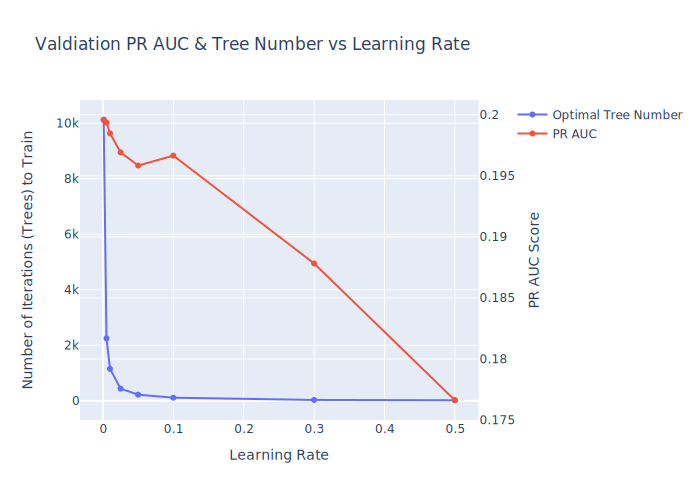

In [14]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=lrs, y=best_iters, name="Optimal Tree Number"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=lrs, y=prs, name="PR AUC"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Valdiation PR AUC & Tree Number vs Learning Rate"
)

# Set x-axis title
fig.update_xaxes(title_text="Learning Rate")

# Set y-axes titles
fig.update_yaxes(title_text="Number of Iterations (Trees) to Train", secondary_y=False)
fig.update_yaxes(title_text="PR AUC Score", secondary_y=True)

fig.show(renderer='svg')

As can be seen, lower learning rate indeed results in more iterations and higher PR AUC. From the plot above, the optimal learning rate would actually be `0.005` since it has almost the same PR AUC as `0.001` but it takes 5 times less iterations to train. If you have time, do perform this type of analysis, since it will ensure that you deploy the simplest yet performant model.

### Final Model

In [41]:
lgb_tuned = LGBMClassifier(
        n_estimators=100000,
        learning_rate=0.005,
        verbose=0,
        **study.best_trial.params
)

lgb_tuned.fit(
    train[features],
    train[label],
    eval_set=[(val[features], val[label])],
    callbacks=[log_evaluation(period=100), early_stopping(30)],
)

train_preds = lgb_tuned.predict_proba(train[features])[:, 1]
val_preds = lgb_tuned.predict_proba(val[features])[:, 1]
test_preds = lgb_tuned.predict_proba(test[features])[:, 1]

train_pr = average_precision_score(train[label], train_preds)
val_pr = average_precision_score(val[label], val_preds)
test_pr = average_precision_score(test[label], test_preds)

print('Tuned LGBM Train PR AUC:', train_pr)
print('Tuned LGBM Val PR AUC:', val_pr)
print('Tuned LGBM Test PR AUC:', test_pr)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.0581684
[200]	valid_0's binary_logloss: 0.0547361
[300]	valid_0's binary_logloss: 0.0526889
[400]	valid_0's binary_logloss: 0.0512847
[500]	valid_0's binary_logloss: 0.0502991
[600]	valid_0's binary_logloss: 0.0496006
[700]	valid_0's binary_logloss: 0.0490935
[800]	valid_0's binary_logloss: 0.0486987
[900]	valid_0's binary_logloss: 0.0483893
[1000]	valid_0's binary_logloss: 0.0481486
[1100]	valid_0's binary_logloss: 0.0479707
[1200]	valid_0's binary_logloss: 0.047832
[1300]	valid_0's binary_logloss: 0.0477113
[1400]	valid_0's binary_logloss: 0.0476217
[1500]	valid_0's binary_logloss: 0.0475522
[1600]	valid_0's binary_logloss: 0.0474964
[1700]	valid_0's binary_logloss:

With this final model, we've achieved great improvements to PR AUC (1.23x). The final model is quite complex and large, yet the degree of overfitting is acceptable. 

# Conclusions

Overall, we've explored how to do hyperparameter tuning for 2 ensamble tree based models - Random Forest and Gradient Boosting (LightGBM). We've used Optuna for this and expored how different HPs affest the bias variance tradeoff. Below you can find some points to keep in mind while tuning your models:
* Always think of HP tuning as the process of discovering the optimal bias/variance tradeoff for the model
* Always know the key parameters to tune - what they are and what they do. If you're unsure about the theory behind them, read the documentation or watch tutorials (e.g. [StatsQuest](https://www.youtube.com/@statquest) has great series about RF and GBTs)
* Always sense check your HPs after tuning them. E.g `max_depth` of 1 is never a good idea, so there might be some issues with your pipeline. That's why it's important to know what the parameters mean
* **Never put too much time into HP tuning**. You're better off spending more time on feature engineering to improve the model results. HP tuning will allow you to squeeze the bits of performance but the increase in performance is really marginal. 